# Домашнее задание

### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.


### Часть 1. Анализ текстов
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

## Посмотрим пример отзыва

In [53]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm
from collections import Counter

In [54]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [55]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

/home/polina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

In [56]:
# Сколько всего записей:
len(responses)

153499

In [57]:
# Пример отзыва:
responses[1234]

{'city': 'г. Воронеж',
 'rating_not_checked': False,
 'title': 'Платеж через терминал Сбербанка',
 'num_comments': 0,
 'bank_license': 'лицензия № 1481',
 'author': 'nadivlasova',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-05-24 18:28:14',
 'text': 'Добрый день!  14.05.15 я оплатила наличными через терминал Сбербанка счет проводного интернета Билайн. Все данные были введены верно, однако платеж не поступил на счет. В колл-центре Сбербанка, куда я обратилась, мне сказали подождать 3 банковских (то есть рабочих) дня. Но и в течение 3х рабочих дней платеж не был зачислен.  20.05.15 я обратилась в отделение Сбербанка (г. Воронеж, доп.офис 9013/0139, ул. Новгородская, 121), где совершала платеж. Сотрудник Людмила Н-а, принявшая у меня паспорт и чек, сказала, что проверит информацию.  В итоге я ждала 20 минут, о времени ожидания меня не предупредили, о причинах задержки тоже. Начальник доп. офиса подошла к Людмиле Н-й и сделала ей замечание, так как, видимо, она слишком долго рассма

### Часть 1. Анализ текстов

In [58]:
data = pd.DataFrame(responses)

In [59]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


#### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [61]:
# Всего банков
len(data['bank_name'].unique())

670

In [62]:
# Количество отзывов по банкам:
data['bank_name'].value_counts()

Сбербанк России                            26327
Альфа-Банк                                 10224
ВТБ 24                                      8185
Русский Стандарт                            7943
Хоум Кредит Банк                            7549
                                           ...  
Северный Народный Банк                         1
Академический Русский Банк                     1
Булгар Банк                                    1
Тульский Промышленник — Московский офис        1
Держава                                        1
Name: bank_name, Length: 670, dtype: int64

In [63]:
# Количество отзывов по городам:
#data['city'].value_counts()

In [64]:
# Уберем строки, где поле город пустое
data = data.dropna(subset = {'city'})

In [65]:
# Всего вариантов в поле "Город":
len(unique(data['city']))

5823

Используем библиотеку natasha, чтобы нормализовать названия городов:

In [66]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

In [67]:
def normalize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    normals = []
    for span in doc.spans:
        if span.type == 'LOC':
            span.normalize(morph_vocab)
            normals.append(span.normal)
    normals_str = ' '.join((str(n) for n in normals))
    normals_str = normals_str.lower()
    return normals_str

In [68]:
data['city_normalized'] = data['city'].apply(lambda x: normalize(str(x)))

In [69]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,city_normalized
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,москва
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,новосибирск
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,москва
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,ставрополь
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,челябинск


In [70]:
# всего "городов" после обработки:
len(unique(data['city_normalized']))

2828

In [71]:
#отзывы по городам:
data['city_normalized'].value_counts()

москва                                       55702
санкт-петербург                              14478
                                              9205
екатеринбург                                  2353
новосибирск                                   2316
                                             ...  
малоярославецкий район                           1
орел-москва                                      1
москва калуга                                    1
волчиха волчихинский район алтайский край        1
каменск ростовская область                       1
Name: city_normalized, Length: 2828, dtype: int64

In [72]:
# посчитаем количество "городов" с одним отзывом:
vals = data['city_normalized'].value_counts()
vals = vals[vals < 2]
len(vals)

1744

In [73]:
# всего записей:
len(data)

138325

In [74]:
len(vals)/len(data)*100

1.2607988433038135

Все же видно, что этой обработки недостаточно, так как могут оставаться такие варианты, как "новосибирк москва","уфа ульяновск" и другие. Однако доля таких записей от общего количества отзывов - всего 1,26 процента. Будем считать их выбросами, и что в какой-то момент можем их не учитывать.

2. Постройте гистограмы длин слов в символах и в словах

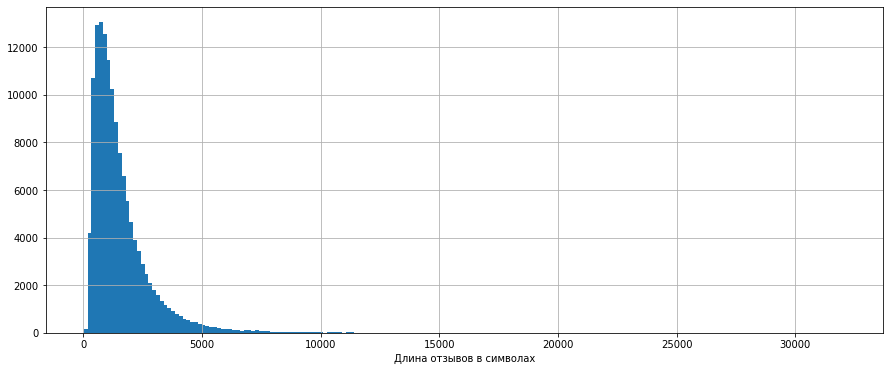

In [75]:
# В символах:
symbols = data['text'].apply(len)
rcParams['figure.figsize'] = 15, 6
symbols.plot(kind='hist',bins=200, grid = 'on')
plt.xlabel('Длина отзывов в символах')
plt.ylabel('')
plt.show()

In [ ]:
# В словах:
words =  data['text'].str.split().apply(len)
rcParams['figure.figsize'] = 15, 6
words.plot(kind='hist',bins=200, grid = 'on')
plt.xlabel('Длина отзывов в словах')
plt.ylabel('')
plt.show()

In [ ]:
# В словах, где меньше 2000 слов:
words =  data['text'].str.split().apply(len)
rcParams['figure.figsize'] = 15, 6
words[words<2000].plot(kind='hist',bins=200, grid = 'on')
plt.xlabel('Длина отзывов в словах')
plt.ylabel('')
plt.show()

Найдите 10 самых частых:  
- слов  
- слов без стоп-слов  
- лемм  
- существительных  

#### Слова

In [ ]:
data['text'][0]

In [ ]:
segmenter = Segmenter()

In [ ]:
def extract_words(text):
    doc_string = re.sub(r'[^\w\s]', '', text)
    doc_string = doc_string.lower()
    doc = Doc(doc_string)
    doc.segment(segmenter)
    tokens = []
    for token in doc.tokens:
        tokens.append(token.text)

    return tokens

In [ ]:
words = pd.DataFrame(data['text'].apply(lambda x: extract_words(str(x))))

In [ ]:
words.head()

In [ ]:
cnt = Counter()

In [ ]:
for index, row in words.iterrows(): 
    cnt.update(row['text'])

In [ ]:
cnt.most_common(10) 

#### Cлов без стоп-слов

In [ ]:
from nltk.corpus import stopwords

stopwords_ext = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'т', 'д', 'г']

In [ ]:
def remove_digits(parts):
    for part in parts:
        if part.isnumeric():
            parts.remove(part)
    return parts

In [ ]:
def remove_stopwords(text, stopwords_list):
    try:
        text = remove_digits(text)
        return " ".join([word for word in text if not word in stopwords_list])
    except:
        return ""

In [ ]:
words_clean = words.copy()

In [ ]:
words_clean['text_clean'] = words_clean['text'].apply(lambda x: remove_stopwords(x,stopwords_ext))

In [ ]:
words_clean

In [ ]:
cnt = Counter()

for index, row in words_clean.iterrows(): 
    cnt.update(row['text_clean'].split())

In [ ]:
cnt.most_common(10) 

#### Леммы

In [ ]:
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

In [ ]:
m = Mystem()

def lemmatize(text, mystem=m):
    try:
        return " ".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [ ]:
words_clean['lemmatized'] = words_clean['text_clean'].apply(lemmatize)

In [ ]:
words_clean['lemmatized']

In [ ]:
cnt = Counter()
lemmas = []
words_number = []

for index, row in words_clean.iterrows():
    lemmas.append(len(cnt))
    words_number.append(sum(cnt.values()))
    cnt.update(row['lemmatized'].split())

In [ ]:
cnt.most_common(10) 

#### Существительные

In [241]:
m=MorphAnalyzer()

def to_noun(text):
    m=MorphAnalyzer()
    try:
        res = " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
        return res
    
    except:
        return []

to_noun(words_clean['lemmatized'].iloc[10])

'оценка итог клиент альфабанка год кредит сумма карта условие платеж день девушка просрочка связь яндексденьги карта кредит банк продукт апрель кредит продукт шок кредит альфа отделение претензия трубка апрель год заявка кредит мотосалон заявка минианкетка сайт взнос момент вариант рассрочка салон отказ банк претензия смска претензия решение время суд развлечение голова шок пора альфабанк'

In [244]:
words_clean['nouns'] = words_clean['lemmatized'].apply(lambda x: to_noun(x))

KeyboardInterrupt: 

In [ ]:
for index, row in words_clean.iterrows():  
    cnt.update(row['nouns'].split())

In [ ]:
cnt.most_common(10) 

### 4. Постройте кривые Ципфа и Хипса

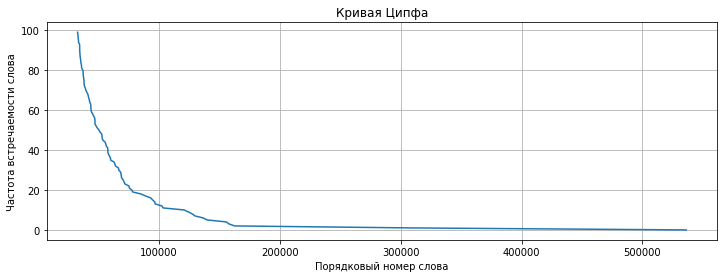

In [49]:
frequency = sorted(list(cnt.values()),reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(frequency[:100], range(100))
grid(visible = 'True')
plt.xlabel('Порядковый номер слова')
plt.ylabel('Частота встречаемости слова')
plt.title('Кривая Ципфа')
plt.show()

TypeError: float() argument must be a string or a number, not 'dict_values'

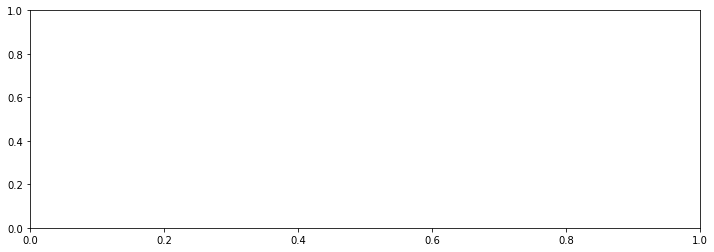

In [50]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(words_number,lemmas)
plt.xlabel('Количество разных слов')
plt.ylabel('Количество слов в тексте')
plt.title('Кривая Хипса')
plt.show()

### Часть 2. Тематическое моделирование

#### 1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [ ]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [ ]:
words_theme = words_clean.copy()
texts = [words_theme['lemmatized'].iloc[i].split() for i in range(len(words_theme))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
random.seed(5)

In [ ]:
# построим модель для 20 тем
lda20 = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=20, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [ ]:
# Посмотрим 3 темы:
lda20.show_topics(3)

Темы:
1. Судебные иски и влияние их на взаимодействие клиента с банком (просьбы об отсрочке и тд)
2. Качество обслуживания клиентов сотрудниками банка
3. Сложно интерпретировать эту тему, но, возможно, проблемы с кредитными выплатами у клиента.

In [ ]:
# построим модель для 10 тем
lda10 = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=10, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [ ]:
# Посмотрим 3 темы:
lda10.show_topics(3)

Темы:
1. Правовые вопросы при заключении договора с банком
2. Возможные жалобы на время/качество работы отделений банка
3. Отзывы на работу сотрудников банка

In [ ]:
# построим модель для 5 тем
lda5 = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=5, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [ ]:
# Посмотрим 3 темы:
lda5.show_topics(3)

1. Кредит в банке, кредитный договор
2. Получение денег в банкомате и в отделении банка
3. Сотрудник банка при работе с клинтом по вкладу

### 2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [ ]:
for theme in lda5.show_topics():
    if theme[1].find('сбербанк')> 0:
        print(theme)

Получение, вопросы, связанные с получением денег  в банкомате Сбербанка и в отделении

In [ ]:
for theme in lda20.show_topics():
    if theme[1].find('сбербанк')> 0:
        print(theme)

Вопросы, проблемы по смс-банкингу

## Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). 

2. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.  
3. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  𝑛 -грам.  
4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [ ]:
dataset = data.copy()
dataset.head(1)

In [ ]:
words_clean.head(1)

In [ ]:
dataset['text_clean'] = words_clean['text_clean']
dataset['lemmatized'] = words_clean['lemmatized']

In [ ]:
dataset.head(1)

In [ ]:
dataset.info()

In [ ]:
dataset = dataset.dropna(subset = {'rating_grade'})
dataset = dataset[(dataset['rating_grade'] == 1.0) | (dataset['rating_grade'] == 5.0)]
dataset.head(3)

In [ ]:
dataset = dataset[0:2000]

In [ ]:
dataset.rating_grade.value_counts()

In [ ]:
X = dataset['lemmatized'].values
y = dataset.rating_grade.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']  
}

scores=['accuracy', 'f1']

In [ ]:
grid_cntv = GridSearchCV(
    clf_countvectorized, 
    param_grid=params_cntv, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [ ]:
grid_cntv.fit(X_train, y_train)